# **Volatility Skew Trading**

Volatility skew is a well-known phenomenon in the options market that refers to the difference in implied volatility (IV) between out-of-the-money (OTM) calls and puts. This skew arises from market sentiment, supply and demand imbalances, and behavioral factors — most notably loss aversion.

## Why Trade the Skew?

Options were originally introduced as hedging instruments, and many investors are willing to overpay for downside protection. This behavioral bias is well described by **Prospect Theory** (Kahneman & Tversky, 1979), which suggests that individuals tend to overweight small-probability events and exhibit strong aversion to losses.

As options traders, we can exploit these persistent mispricings by constructing volatility skew trading strategies, aiming to profit when market-implied fears (e.g., demand for puts) fail to materialize. These strategies typically assume that the pricing dislocation is temporary or exaggerated relative to actual realized outcomes.

The notebook is structured as follows:
1. [Read SPX Options Data](#read)
2. [Plot the Volatility Skew](#plot)
3. [Compute the Skew](#skew)
3. [Conclusion](#conclusion)

## Import Libraries

In [75]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from utility import remove_illiquid_options, reshape_options_long_to_wide, reshape_options_wide_to_long
from config.constants import OPTION_TYPES

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
file = "data/intermediate/spx_options_2023_2023.parquet"

cols = [
    "strike", "underlying_last", 
    "dte", "expiry",
    "c_delta", "p_delta", 
    "c_iv", "p_iv",
    "c_last", "p_last",
    "c_volume", "p_volume",
    "c_bid", "c_ask",
    "p_bid", "p_ask"
]

options = pd.read_parquet(file, columns=cols)
options

,strike,underlying_last,dte,expiry,c_delta,p_delta,c_iv,p_iv,c_last,p_last,c_volume,p_volume,c_bid,c_ask,p_bid,p_ask
date,,,,,,,,,,,,,,,,
2023-01-04,1000.0,3853.39,27.0,2023-01-31,1.00000,0.00000,NaN,1.35367,0.00,0.00,0.0,0.0,2845.7,2854.60,0.0,0.05
2023-01-04,1200.0,3853.39,27.0,2023-01-31,1.00000,0.00000,NaN,1.17498,2623.64,0.10,1.0,10.0,2643.4,2651.80,0.0,0.05
2023-01-04,1400.0,3853.39,27.0,2023-01-31,1.00000,-0.00031,NaN,1.02388,2377.30,0.07,1.0,2.0,2444.1,2453.70,0.0,0.05
2023-01-04,1500.0,3853.39,27.0,2023-01-31,1.00000,0.00000,NaN,0.95679,0.00,0.10,0.0,1.0,2347.4,2355.90,0.0,0.05
2023-01-04,1600.0,3853.39,27.0,2023-01-31,1.00000,-0.00029,NaN,0.89294,2183.32,0.05,2.0,2.0,2244.6,2253.10,0.0,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29,5800.0,4772.17,0.0,2023-12-29,0.00084,-0.92248,1.27964,2.46351,0.05,1186.49,5.0,44.0,0.0,0.05,1028.3,1029.90
2023-12-29,5900.0,4772.17,0.0,2023-12-29,0.00027,-0.91952,1.38397,2.68042,0.07,1108.69,3.0,123.0,0.0,0.05,1128.0,1129.30
2023-12-29,6000.0,4772.17,0.0,2023-12-29,0.00026,-0.91572,1.48449,2.91246,0.05,0.00,6.0,0.0,0.0,0.05,1228.0,1229.20


## Plot the Skew

In [58]:
dates = options.sample(3).index

In [59]:
def compute_iv_smile(options, date):
    options_red = options.loc[options.index == date].copy()

    atm_idx = (options_red["strike"] - options_red["underlying_last"]).abs().argmin()
    atm_strike = options_red.iloc[atm_idx]["strike"]
    options_red["atm_strike"] = atm_strike

    # Keep only strikes within ±1000 of ATM
    options_red = options_red[((options_red['strike'] - options_red['atm_strike']).abs() <= 1000)]

    # Build IV smile
    options_red['iv_smile'] = np.where(
        options_red['strike'] < atm_strike,
        options_red['p_iv'],
        np.where(
            options_red['strike'] > atm_strike,
            options_red['c_iv'],
            0.5 * (options_red['c_iv'] + options_red['p_iv'])  # At-the-money
        )
    )
    options_red = options_red.set_index("strike")

    return options_red["iv_smile"]

In [60]:
iv_smiles = {}
for date in dates:
    iv_smile = compute_iv_smile(options, date)
    iv_smiles[date] = iv_smile

In [61]:
def plot_iv_smiles(iv_smiles, ticker):
    plt.figure(figsize=(15, 7))

    for date, iv_smile in iv_smiles.items():
        plt.scatter(iv_smile.index, iv_smile, label=date.strftime('%Y-%m-%d'))

    plt.xlabel('Strike')
    plt.ylabel('IV')
    plt.title(f'Implied Volatility Smile for {ticker} Options')
    plt.legend()
    plt.grid(True)
    plt.show()

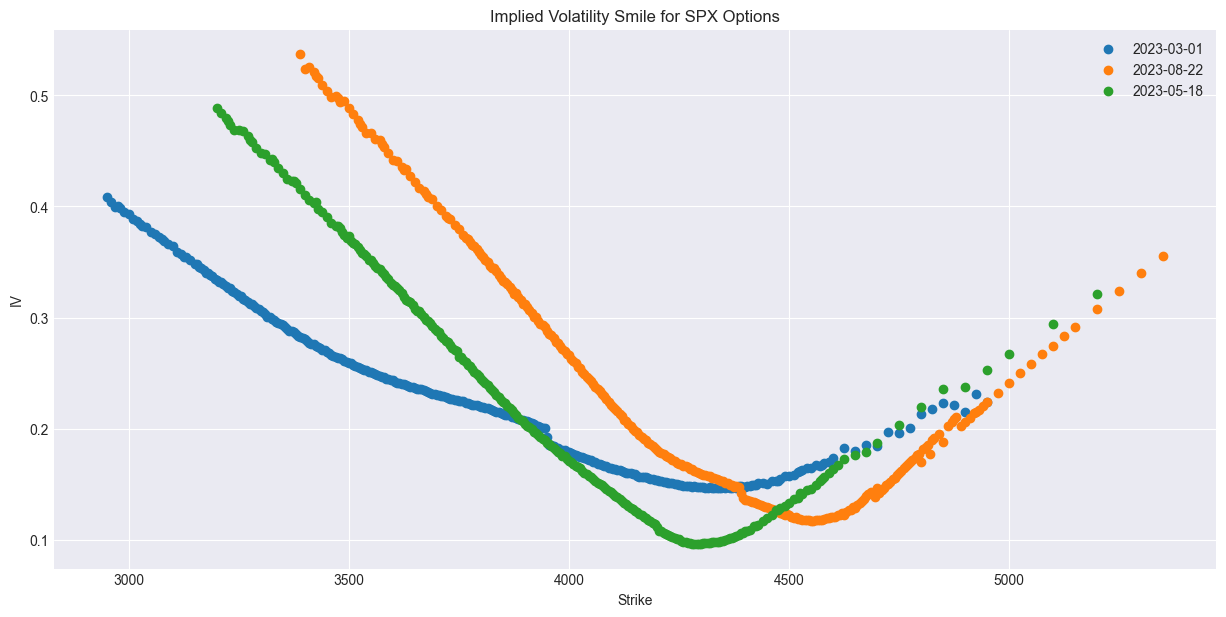

In [62]:
plot_iv_smiles(iv_smiles, "SPX")

As we can see the shape of the smile can change drastically over time, but over the short term it tends to cluster. 

We can also notice the few transactions for deep OTM Call compared to Puts, which is explained by the investors' demand for tail protection against downside moves.

## Remove illiquid options

In order to obtain more reliable backtest results, we are going to remove illiquid options as trading them would lead to high slippage, bid-ask spread which can maek our edge vanish. 

In [ ]:
options = reshape_options_wide_to_long(options)
options.head()

### Volume Filter

Since Open Interest is not available in our dataset, we use daily traded **volume** as a proxy for option contract liquidity. While not a perfect substitute, volume provides a reasonable indication of market activity and tradability. 

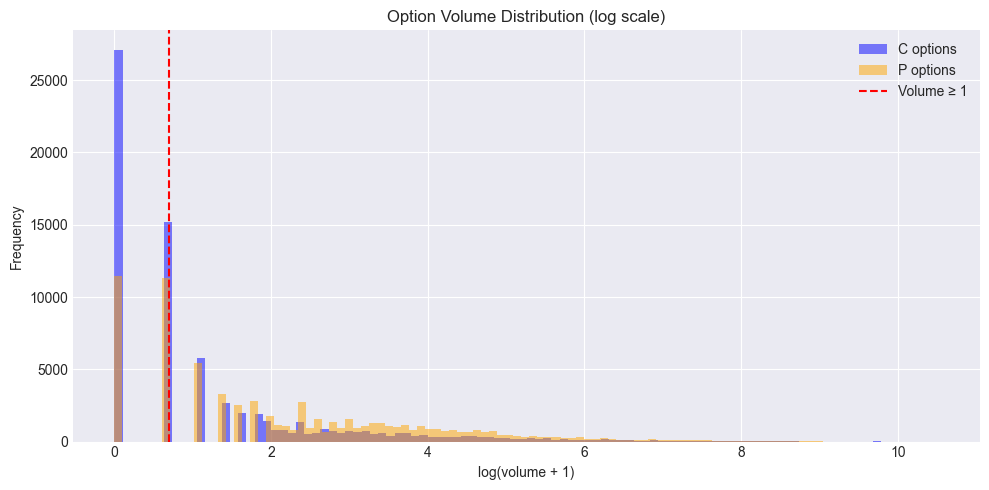

In [88]:
# Add 1 to avoid log(0), then take log
log_volumes = (options["volume"] + 1).apply(np.log)

# Plot histogram
plt.figure(figsize=(10, 5))

for opt_type, color in zip(OPTION_TYPES, ["blue", "orange"]):
    subset = options[options["option_type"] == opt_type]
    log_volumes = (subset["volume"] + 1).apply(np.log)
    log_volumes.hist(bins=100, alpha=0.5, label=f"{opt_type} options", color=color)

# Reference line at log(2) ≈ volume = 1
plt.axvline(np.log(2), color='r', linestyle='--', label='Volume ≥ 1')
plt.title("Option Volume Distribution (log scale)")
plt.xlabel("log(volume + 1)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We remove options with very low volume (e.g., volume < 1), as these are likely illiquid and may not reflect reliable pricing or realistic execution.

In [ ]:
options = options[options["volume"] >= 1].copy()

### Bid-Ask Spread Filter

The bid-ask spread is a key measure of transaction cost and liquidity. Options with wide spreads are harder to trade efficiently and may reflect stale or unreliable pricing.

First we drop 0 ask and bid values, as they indicate that no trading occured at a particular date for a specific option.


In [80]:
options = options[(options["bid"] > 0) & (options["ask"] > 0)].copy()

Now we filter out options where the **relative bid-ask spread** exceeds a threshold (e.g., 25%), defined as:

$$
\text{Relative Spread} = \frac{\text{Ask} - \text{Bid}}{0.5 \times (\text{Ask} + \text{Bid})}
$$

In [ ]:
options["mid"] = 0.5 * (options["bid"] + options["ask"])
options["rel_spread"] = (options["ask"] - options["bid"]) / options["mid"]

options[["bid", "ask", "mid", "rel_spread"]]

,bid,ask,mid,rel_spread
date,,,,
2023-01-04,2845.7,2854.6,2850.15,0.003123
2023-01-04,2643.4,2651.8,2647.60,0.003173
2023-01-04,2444.1,2453.7,2448.90,0.003920
2023-01-04,2347.4,2355.9,2351.65,0.003614
2023-01-04,2244.6,2253.1,2248.85,0.003780
...,...,...,...,...
2023-12-29,1028.3,1029.9,1029.10,0.001555
2023-12-29,1128.0,1129.3,1128.65,0.001152
2023-12-29,1228.0,1229.2,1228.60,0.000977


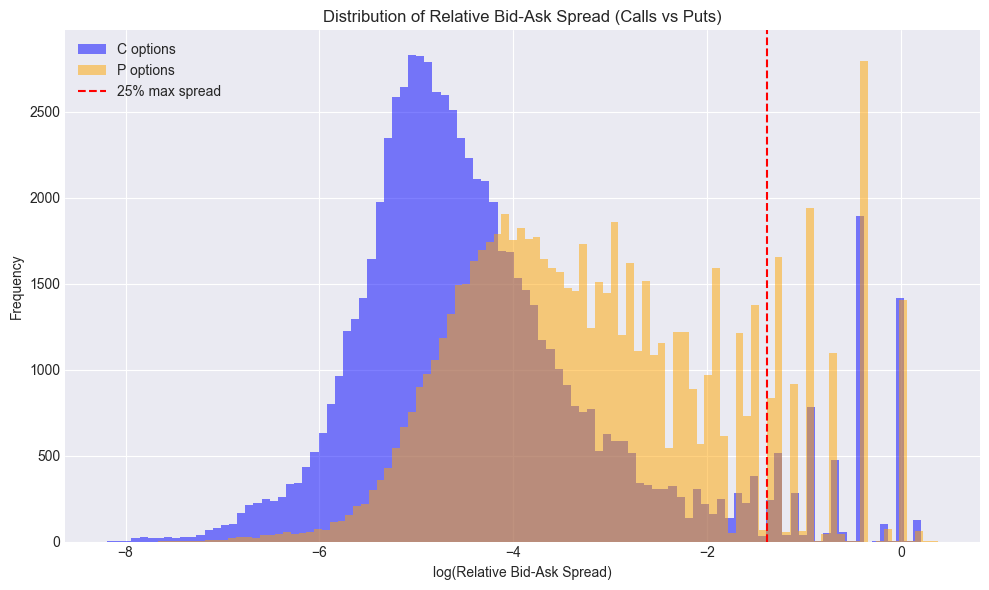

In [86]:
plt.figure(figsize=(10, 6))

for opt_type, color in zip(OPTION_TYPES, ["blue", "orange"]):
    subset = options[options["option_type"] == opt_type]
    log_rel_spread = (subset["rel_spread"] + 1e-6).apply(np.log)
    log_rel_spread.hist(bins=100, alpha=0.5, label=f"{opt_type} options", color=color)

plt.axvline(np.log(0.25), color='red', linestyle='--', label="25% max spread")
plt.xlabel("log(Relative Bid-Ask Spread)")
plt.ylabel("Frequency")
plt.title("Distribution of Relative Bid-Ask Spread (Calls vs Puts)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

A threshold of 25% seems a reasonble choice for removing too large bid-ask spreads.

In [91]:
options = options[options["rel_spread"] <= 0.25].copy()

### Moneyness filter

We filter options based on their moneyness (strike / underlying price) to focus on contracts with meaningful market activity. Deep ITM or far OTM options are often illiquid or mispriced, so we retain only those within a reasonable band (e.g., 0.8 to 1.2).

In [ ]:
options["moneyness"] = options["strike"] / options["underlying_last"]

options["moneyness_bin"] = pd.cut(
    options["moneyness"],
    bins=np.arange(0.5, 1.6, 0.05),
    include_lowest=True
)

avg_vol = (
    options.groupby(["option_type", "moneyness_bin"])["volume"]
    .mean()
    .reset_index()
)

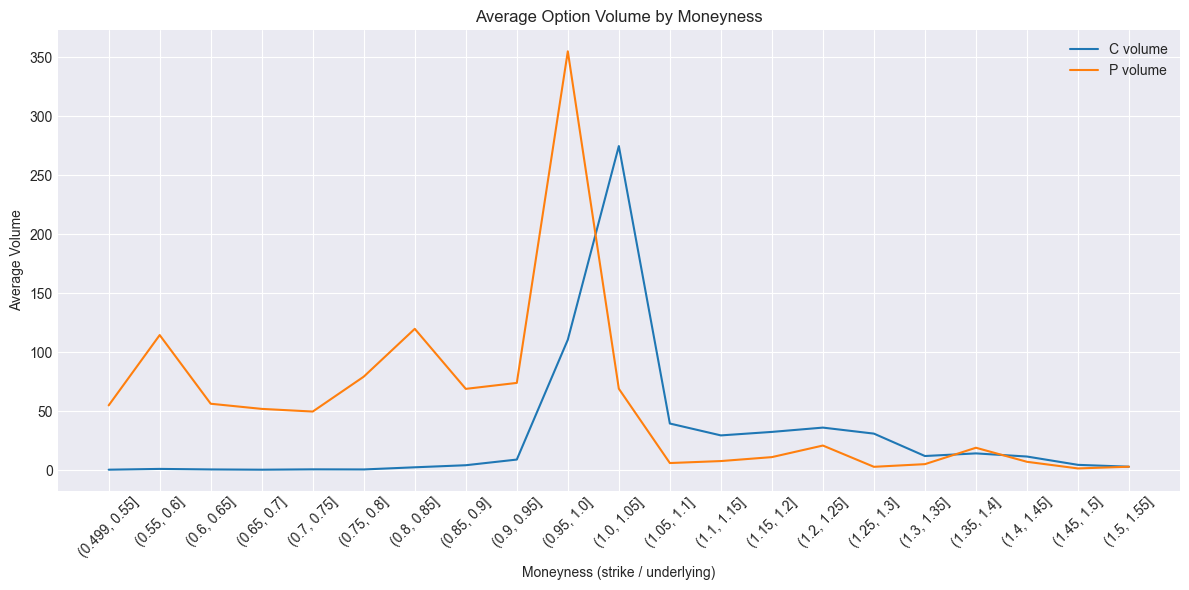

In [92]:
plt.figure(figsize=(12, 6))

for option_type in OPTION_TYPES:
    subset = avg_vol[avg_vol["option_type"] == option_type]
    plt.plot(
        subset["moneyness_bin"].astype(str),
        subset["volume"],
        label=f"{option_type} volume"
    )

plt.xticks(rotation=45)
plt.xlabel("Moneyness (strike / underlying)")
plt.ylabel("Average Volume")
plt.title("Average Option Volume by Moneyness")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We observe that average volume for OTM Calls drops sharply beyond a moneyness of 1.2, indicating low liquidity. For OTM Puts, volume remains relatively high down to a moneyness of 0.8, but falls off below that. Therefore, we retain options within the band [0.8, 1.2] to focus on the most liquid and tradeable strikes.

In [ ]:
options = options[(options["moneyness"] >= 0.8) & (options["moneyness"] <= 1.2)]

## Compute the skew

As already introduced earlier, the skew is an observed phenoma in options markets where the Implied volatility is usually difefrent with various strike levels. As systematic traders, a measure of this skew is necessary to quantitify this difference of Iv across strikes. For that, we are going to introduce 2 measures and will compare their differences and potential impact on our trading system in general.

In [ ]:

# TODO: COmpue the skew usign standard method and comapre with delta skew

# TODO: Inteoduce the backetsting logic, teh filters we will be using, and see teh diff between the 2

# TODO: Use advanced signals like BB, time the entry/exit based on a forecasting model

# TODO: Present advanced strategies like Implied Skew vs RV Skew, Skew disperisoon

## Construct the strategy

In [ ]:
spy = yf.download("SPY", start=options.index[0], end=options.index[-1])["Close"]
spy

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_64717/2389249413.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start=options.index[0], end=options.index[-1])["Close"]
[*********************100%***********************]  1 of 1 completed


Ticker,SPY
Date,
2023-01-04,371.011017
2023-01-05,366.776520
2023-01-06,375.187469
2023-01-09,374.974762
2023-01-10,377.604462
...,...
2023-12-21,463.942047
2023-12-22,464.874420
2023-12-26,466.837311


In [ ]:
data = pd.merge(options, spy["Close"], left_index=True, right_index=True)
data

,STRIKE,C_LAST,C_DELTA,P_DELTA,P_LAST,SPX,SPY
Date,,,,,,,
2015-01-02,1325.0,731.10,1.00000,-0.00326,0.35,2058.69,171.568024
2015-01-02,1550.0,529.00,1.00000,-0.00824,0.65,2058.69,171.568024
2015-01-02,1875.0,195.70,0.91401,-0.08038,6.03,2058.69,171.568024
2015-01-02,1890.0,171.70,0.90085,-0.09234,7.20,2058.69,171.568024
2015-01-02,1895.0,177.90,0.89560,-0.09006,7.63,2058.69,171.568024
...,...,...,...,...,...,...,...
2022-09-29,5050.0,0.25,0.00084,-1.00000,990.51,3641.71,349.134430
2022-09-29,5200.0,0.15,0.00040,-1.00000,1556.70,3641.71,349.134430
2022-09-29,5450.0,0.10,0.00058,-1.00000,1539.98,3641.71,349.134430


In [ ]:
spx_spy_corr = data[["SPX", "SPY"]].corr().iloc[0, 1]
print("Correlation between SPX Index and SPY ETF:", spx_spy_corr)

#data.drop("SPX", axis=1, inplace=True)

Correlation between SPX Index and SPY ETF: 0.9992109585255068


Here we can use the SPY ETF as a proxy for the SPX inde which is not tradeable.